# Goodness of fit and fitted parameters of dynamical models

In [1]:
import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, pearsonr, spearmanr
from statsmodels.stats.weightstats import DescrStatsW

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("models/ddm")
model_path = '../models/ddm/'

downloading models/ddm...
models/ddm already exists. Skipping download...


In [3]:
from src.model_ddm import model
sys.modules['model'] = model

models = {}
files  = sorted([f for f in os.listdir(model_path+'full') if ('.pkl' in f)])
for v_f in files:
    with open(model_path+'full/'+v_f, 'rb') as f:
        _model = pickle.load(f)
    models[v_f[17:21]] = _model
    
name_par = ['w_K', 'w_E', 'w_P', 'w_D', 'w_r', 'w_b', 'lambda', 's']
name_par_latex = [r'$w_K$', r'$w_E$', r'$w_P$', r'$w_D$', r'$w_r$', r'$w_\beta$', r'$w_\lambda$', r'$s$']

fit_par_value_full = {}
for i,n in enumerate(name_par):
    fit_par_value_full[n] = np.nan*np.zeros(50)
    for i_sub, (k,v) in enumerate(models.items()):
        fit_par_value_full[n][i_sub] = v.fitted_params[i]
        
lkds_full = np.array([v.loglik for _,v in models.items()])
ns  = np.array([v.mask_cw.shape[-1] for _,v in models.items()])
ll  = lkds_full - np.log(_model.dm*90/np.pi)*ns
bic_full = len(_model.fitted_params) * np.log(ns) - 2*ll

In [4]:
models = {}
files  = sorted([f for f in os.listdir(model_path+'reduced') if ('.pkl' in f)])
for v_f in files:
    with open(model_path+'reduced/'+v_f, 'rb') as f:
        _model = pickle.load(f)
    models[v_f[17:21]] = _model
    
fit_par_value_reduced = {}
for i,n in enumerate(name_par[1:]):
    fit_par_value_reduced[n] = np.nan*np.zeros(50)
    for i_sub, (k,v) in enumerate(models.items()):
        fit_par_value_reduced[n][i_sub] = v.fitted_params[i]
        
lkds_reduced = np.array([v.loglik for _,v in models.items()])
ns  = np.array([v.mask_cw.shape[-1] for _,v in models.items()])
ll  = lkds_reduced - np.log(_model.dm*90/np.pi)*ns
bic_reduced = len(_model.fitted_params) * np.log(ns) - 2*ll

In [5]:
xlims = {}
xlims['w_K'] = [0,5]
xlims['w_E'] = [0,15]
xlims['w_P'] = [0,15]
xlims['w_D'] = [0,5]
xlims['w_r'] = [0,1]
xlims['w_b'] = [-8,8]
xlims['lambda'] = [0,0.15]
xlims['s'] = [0,1]

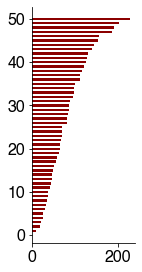

In [6]:
argsort = np.argsort(bic_reduced-bic_full)

plt.figure(figsize=[2.2,4])
plt.barh(np.arange(1,51), (bic_reduced-bic_full)[argsort], align='center', color='darkred', height=0.55)
plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/sfig3a.pdf',bbox_inches='tight')
plt.show()

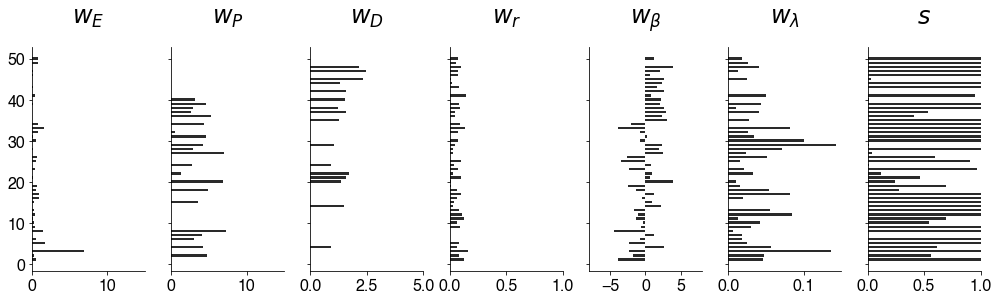

In [7]:
# plot the fitted parameters of the reduced model
f,ax = plt.subplots(1,7,figsize=[14,4.4],sharey=True)
for i,(k,v) in enumerate(fit_par_value_reduced.items()):
    ax[i].set_title(name_par_latex[i+1])
    ax[i].barh(np.arange(1,51), v[argsort], align='center', color='#2a2a2a', height=0.55)
    ax[i].set_xlim(xlims[k])
plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/sfig3b.pdf',bbox_inches='tight')
plt.show()

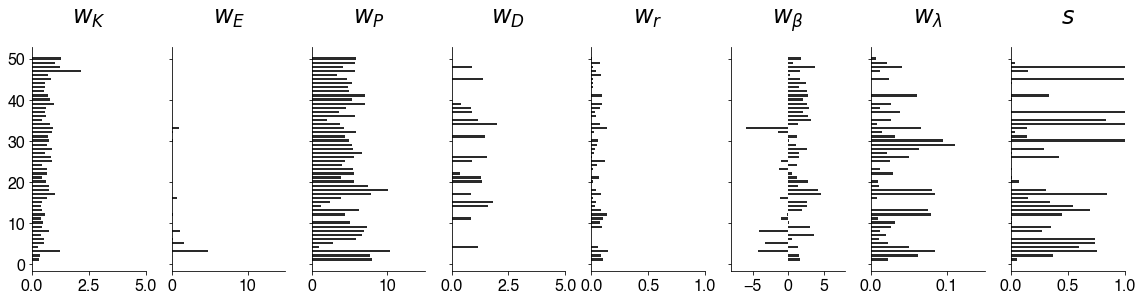

In [8]:
# plot the fitted parameters of the full model
f,ax = plt.subplots(1,8,figsize=[16,4.4],sharey=True)
for i,(k,v) in enumerate(fit_par_value_full.items()):
    ax[i].set_title(name_par_latex[i])
    ax[i].barh(np.arange(1,51), v[argsort], align='center', color='#2a2a2a', height=0.55)
    ax[i].set_xlim(xlims[k])
plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/sfig3c.pdf',bbox_inches='tight')
plt.show()

In [9]:
ttest  = DescrStatsW(fit_par_value_reduced['w_b'])
wilcox = wilcoxon(fit_par_value_reduced['w_b'])
print("Reduced model, w_beta versus 0")
print('Paired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

ttest  = DescrStatsW(fit_par_value_full['w_b'])
wilcox = wilcoxon(fit_par_value_full['w_b'])
print("\nFull model, w_beta versus 0")
print('Paired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

spear = spearmanr(fit_par_value_full['w_K'], (bic_reduced-bic_full))
pears = pearsonr(fit_par_value_full['w_K'], (bic_reduced-bic_full))
pears_CI = utils.pearson_CI(fit_par_value_full['w_K'], (bic_reduced-bic_full))
print("\nCorrelation between w_K and likelihood gain")
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)


spear = spearmanr(fit_par_value_full['w_b'], (bic_reduced-bic_full))
pears = pearsonr(fit_par_value_full['w_b'], (bic_reduced-bic_full))
pears_CI = utils.pearson_CI(fit_par_value_full['w_b'], (bic_reduced-bic_full))
print("\nCorrelation between w_beta and likelihood gain")
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)

Reduced model, w_beta versus 0
Paired samples t-test
t(49)= 0.8519785950004558 p= 0.3983709368740712
95% CI= (-0.35934246868543873, 0.8882868024040058)
Wilcoxon signed-rank test (without continuity correction)
V= 532.0 p= 0.3084779739418636

Full model, w_beta versus 0
Paired samples t-test
t(49)= 3.7145242545905286 p= 0.0005218411011125924
95% CI= (0.5235862930226494, 1.7578590310002322)
Wilcoxon signed-rank test (without continuity correction)
V= 251.0 p= 0.0001907271235485083

Correlation between w_K and likelihood gain
Pearson r= 0.5907724305124925 p= 6.286795794936611e-06
Pearson CI= (0.3739106361453757, 0.7463845547739433)
Spearman rho= 0.5411284513805522 p= 4.960274535232224e-05

Correlation between w_beta and likelihood gain
Pearson r= 0.24251962049978484 p= 0.08970884533582851
Pearson CI= (-0.038421749922212346, 0.4879297472869886)
Spearman rho= 0.2467707082833133 p= 0.084054935318978
